# Markov Chain Monte Carlo em Python

Tradu√ß√£o do artigo de Will Koehrsen _Markov Chain Monte Carlo in Python A Complete Real-World Implementation_, original netse [link](https://towardsdatascience.com/markov-chain-monte-carlo-in-python-44f7e609be98)

Nos √∫ltimos meses, encontrei um termo repetidamente no mundo da ci√™ncia de dados: Markov Chain Monte Carlo.   

No meu laborat√≥rio de pesquisa, em podcasts, em artigos, toda vez que eu ouvia a frase eu acenava com a cabe√ßa e achava que soava muito legal, com apenas uma vaga ideia do que algu√©m estava falando.   

V√°rias vezes tentei aprender MCMC e infer√™ncia bayesiana, mas sempre que comecei a ler os livros, logo desisti. Exasperado, busquei o melhor m√©todo para aprender qualquer nova habilidade: aplic√°-la a um problema.  

Usando alguns dos meus dados de sono que pretendia explorar e um livro pr√°tico baseado em aplicativos (M√©todos Bayesianos para Hackers, dispon√≠vel gratuitamente [online](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)), finalmente aprendi a Cadeia de Markov Monte Carlo por meio de um projeto do mundo real.   

Como de costume, foi muito mais f√°cil (e mais agrad√°vel) entender os conceitos t√©cnicos quando os apliquei a um problema, em vez de l√™-los como ideias abstratas em uma p√°gina.   

Este artigo percorre a implementa√ß√£o introdut√≥ria do Markov Chain Monte Carlo em Python que finalmente me ensinou essa poderosa ferramenta de modelagem e an√°lise.

# Descri√ß√£o do Problema

![image](https://miro.medium.com/max/398/1*_V59tsiXl9HrqmJ4z7oTxQ.png)

Meu rel√≥gio Garmin Vivosmart monitora a hora em que adorme√ßo e acordo todos os dias usando sensor de movimento e monitoramento de frequ√™ncia card√≠aca. Para aumentar esses dados, estimei a probabilidade de estar dormindo com base na condi√ß√£o da luz do meu quarto (ligada / desligada) e se meu telefone est√° carregando (sim / n√£o). Meu objetivo √© usar esses dados para criar um modelo que retorne a probabilidade de estar dormindo em um determinado momento. O objetivo final pode ser expresso matematicamente como:

$$P(\text{sono} | \text{tempo})$$.

Em termos da teoria da probabilidade, essa √© a probabilidade posterior de que estou dormindo, dado o tempo ou o hor√°rio.

# Explora√ß√£o de dados de vig√≠lia e sono

Os dados de vig√≠lia e sono cont√™m mais de dois meses de informa√ß√µes.  

O rel√≥gio Garmin registra quando eu adorme√ßo e acordo com base no movimento e na frequ√™ncia card√≠aca.  

N√£o √© 100% preciso, pois muitas vezes pensar√° que estou dormindo se desligar as notifica√ß√µes e ler tranquilamente na cama. 

√Äs vezes, temos que lidar com dados imperfeitos e, como h√° observa√ß√µes mais verdadeiras do que falsas, podemos esperar que os dados corretos tenham um efeito maior no modelo.

Primeiro, importaremos as bibliotecas necess√°rias e visualizaremos os dados de sono e de vig√≠lia.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib



# Number of samples for Markov Chain Monte Carlo
N_SAMPLES = 5000

In [2]:
plt.style.use('bmh')
matplotlib.rcParams['figure.figsize'] = (10, 3)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['ytick.major.size'] = 20

In [3]:
# Data formatted in different notebook
sleep_data = pd.read_csv('data/sleep_data.csv')
wake_data = pd.read_csv('data/wake_data.csv')

# Labels for plotting
sleep_labels = ['9:00', '9:30', '10:00', '10:30', '11:00', '11:30', '12:00']
wake_labels = ['5:00', '5:30', '6:00', '6:30', '7:00', '7:30', '8:00']

## Dados de adormecimento

Cada ponto representa uma observa√ß√£o em um momento espec√≠fico com a intensidade da cor correspondendo ao n√∫mero de pontos naquele momento. Podemos ver que tenho tend√™ncia a adormecer um pouco depois das 22:00.

In [4]:
print('N√∫mero de observa√ß√µes do sono %d' % len(sleep_data))

N√∫mero de observa√ß√µes do sono 11340


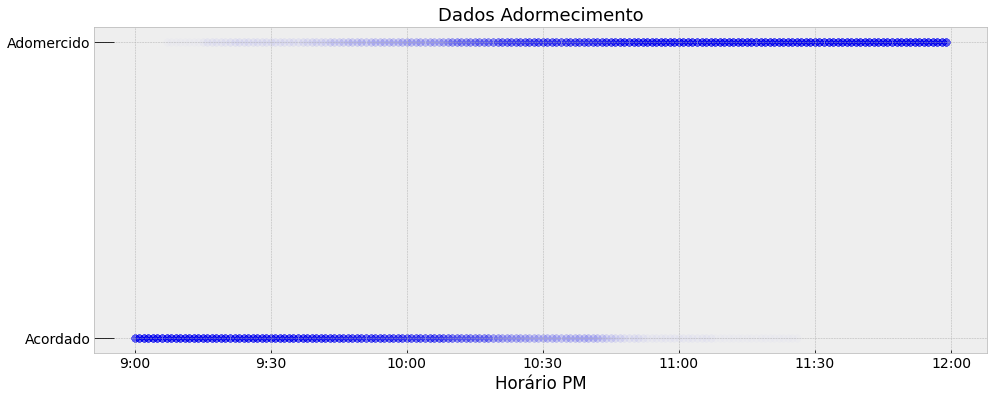

In [5]:
figsize(16, 6)

# Sleep data
plt.scatter(sleep_data['time_offset'], sleep_data['indicator'], 
            s= 60, alpha=0.01, facecolor = 'b', edgecolors='b')
plt.yticks([0, 1], ['Acordado', 'Adomercido']); plt.xlabel('Hor√°rio PM'); 
plt.title('Dados Adormecimento', size = 18)
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

## Dados de Despertar

Meu alarme est√° definido para 6h, todos os dias da semana, e os dados de despertar s√£o mais consistentes do que os dados de sono. Quase sempre acordo dentro de uma janela de 10 minutos, por volta das 6h.

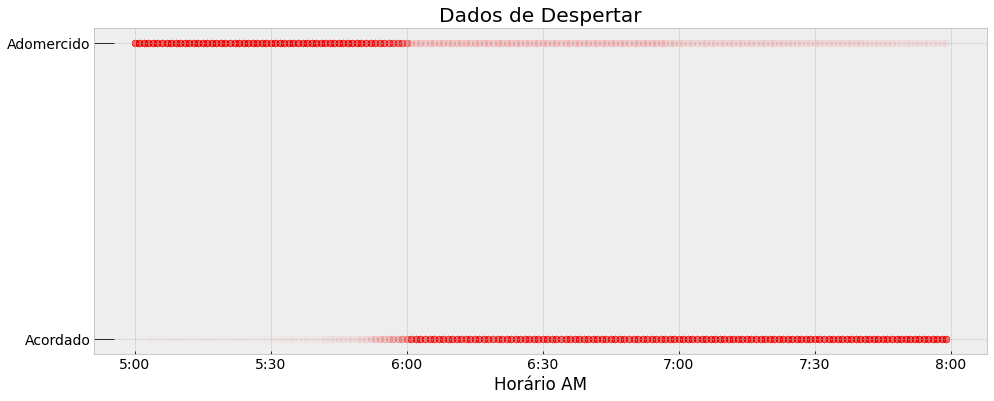

In [6]:
# Wake data
plt.scatter(wake_data['time_offset'], wake_data['indicator'], 
            s= 50, alpha = 0.01, facecolor='r', edgecolors =  'r');
plt.yticks([0, 1], ['Acordado', 'Adomercido']); plt.xlabel('Hor√°rio AM');
plt.title('Dados de Despertar')
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

# Fun√ß√£o Log√≠stica para Representar a Transi√ß√£o

Precisamos decidir sobre uma fun√ß√£o para representar a transi√ß√£o de estar acordado para dormir. Existem v√°rios modelos aceit√°veis e, aqui, assumiremos que essa transi√ß√£o pode ser modelada como uma fun√ß√£o log√≠stica. Uma fun√ß√£o log√≠stica (tamb√©m chamada de sigm√≥ide) √© uma fun√ß√£o n√£o linear limitada entre 0 e 1. Como ${t \to -\infty}, {p(s|t) \to 0}$ e, com ${t \to +\infty}, {p(s|t) \to 1}$. A express√£o para uma distribui√ß√£o de probabilidade log√≠stica para o sono em fun√ß√£o do tempo √©:

$$p(s|t) = \frac{1}{ 1 + e^{\;\beta t } }$$

O par√¢metro $\beta$ √© desconhecido e pode ser estimado usando a amostragem Markov Chain Monte Carlo. Amostras MCMC anteriores para cada par√¢metro, tentando maximizar a probabilidade do par√¢metro dado os dados. 

V√°rias fun√ß√µes log√≠sticas com v√°rios par√¢metros $\beta$ s√£o mostradas abaixo:

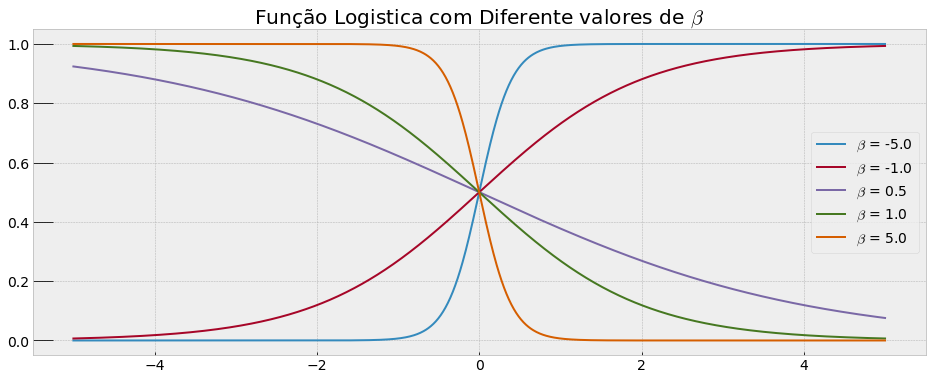

In [7]:
figsize(16, 6)

# Logistic function with only beta
def logistic(x, beta):
    return 1. / (1. + np.exp(beta * x))

# Plot examples with different betas 
x = np.linspace(-5, 5, 1000)
for beta in [-5, -1, 0.5, 1, 5]:
    plt.plot(x, logistic(x, beta), label = r"$\beta$ = %.1f" % beta)

plt.legend();
plt.title(r'Fun√ß√£o Logistica com Diferente valores de $\beta$');

H√° um problema com a fun√ß√£o log√≠stica b√°sica, conforme mostrado acima: a transi√ß√£o √© centrada em 0. No entanto, em meus dados de sono, a transi√ß√£o √© por volta das 22h para dormir e 6h para acordar. Abordamos isso adicionando um deslocamento, chamado de vi√©s, para ajustar a localiza√ß√£o da fun√ß√£o log√≠stica. A fun√ß√£o log√≠stica agora √©:

$$p(t) = \frac{1}{ 1 + e^{\;\beta t + \alpha} }$$

Isso introduz outro par√¢metro desconhecido, $ \ alpha $, que tamb√©m encontraremos em Markov Chain Monte Carlo.

A fun√ß√£o log√≠stica com v√°rios par√¢metros $ \ alpha $ e $ \ beta $ √© mostrada abaixo.

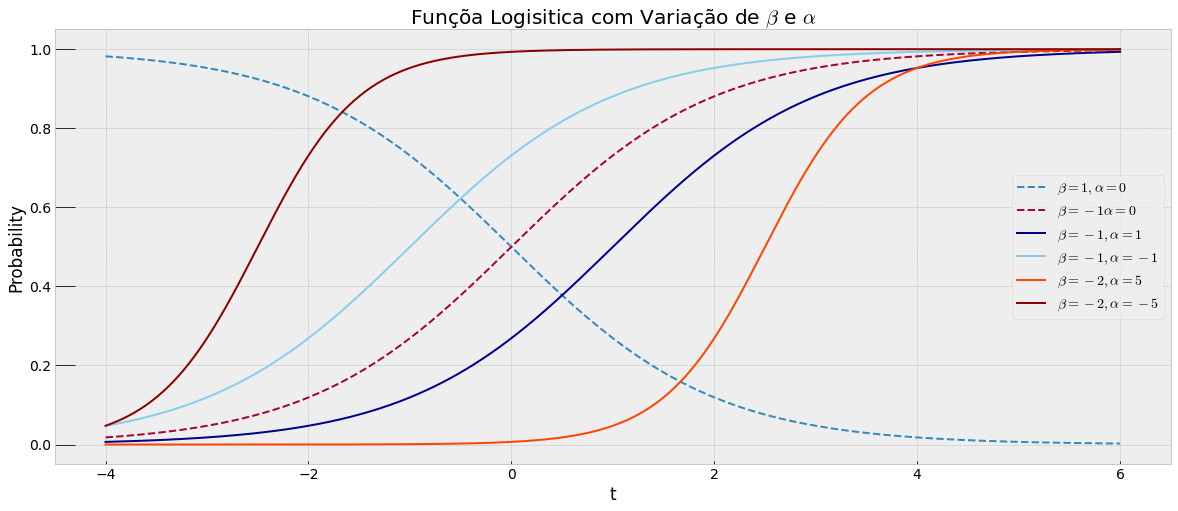

In [9]:
figsize(20, 8)

# Logistic function with both beta and alpha
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 6, 1000)

plt.plot(x, logistic(x, beta=1), label=r"$\beta = 1, \alpha = 0$", ls="--", lw=2)
plt.plot(x, logistic(x, beta=-1), label=r"$\beta = -1 \alpha = 0$", ls="--", lw=2)

plt.plot(x, logistic(x, -1, 1), 
         label=r"$\beta = -1, \alpha = 1$", color="darkblue")
plt.plot(x, logistic(x, -1, -1),
         label=r"$\beta = -1, \alpha = -1$",color="skyblue")
plt.plot(x, logistic(x, -2, 5), 
         label=r"$\beta = -2, \alpha = 5$", color="orangered")
plt.plot(x, logistic(x, -2, -5), 
         label=r"$\beta = -2, \alpha = -5$", color="darkred")
plt.legend(); plt.ylabel('Probability'); plt.xlabel('t')
plt.title(r'Fun√ß√µa Logisitica com Varia√ß√£o de $\beta$ e $\alpha$');

$\beta$ muda a dire√ß√£o e inclina√ß√£o da curva, enquanto $\alpha$ muda a localiza√ß√£o. Usaremos MCMC para encontrar o valor mais prov√°vel desses par√¢metros nos dados.

## Distribui√ß√µa a Priori $\beta$ e $\alpha$

N√£o temos evid√™ncias que sugiram quais s√£o as distribui√ß√µes anteriores para os par√¢metros do modelo $\beta$ e $\alpha$. Portanto, podemos model√°-los como se viessem de uma distribui√ß√£o normal. A distribui√ß√£o normal, ou gaussiana, √© definida pela m√©dia, $\mu$, e pela precis√£o, $\tau$.  

A precis√£o √© o rec√≠proco do desvio padr√£o, $\sigma$. 

A m√©dia define a localiza√ß√£o da distribui√ß√£o e a precis√£o mostra a dispers√£o. 

Um valor maior de $\tau$ indica que os dados est√£o menos espalhados (s√£o mais precisos) e, portanto, a varia√ß√£o √© menor. 

A m√©dia pode ser positiva ou negativa, mas a precis√£o sempre ser√° positiva. Uma distribui√ß√£o normal conforme definida aqui √© representada como:

$$ f(x | \mu, \tau) = \sqrt{\frac{\tau}{2\pi}} \exp\left( -\frac{\tau}{2} (x - \mu)^2 \right) $$

As fun√ß√µes de densidade de probabilidade para tr√™s distribui√ß√µes normais s√£o mostradas abaixo.

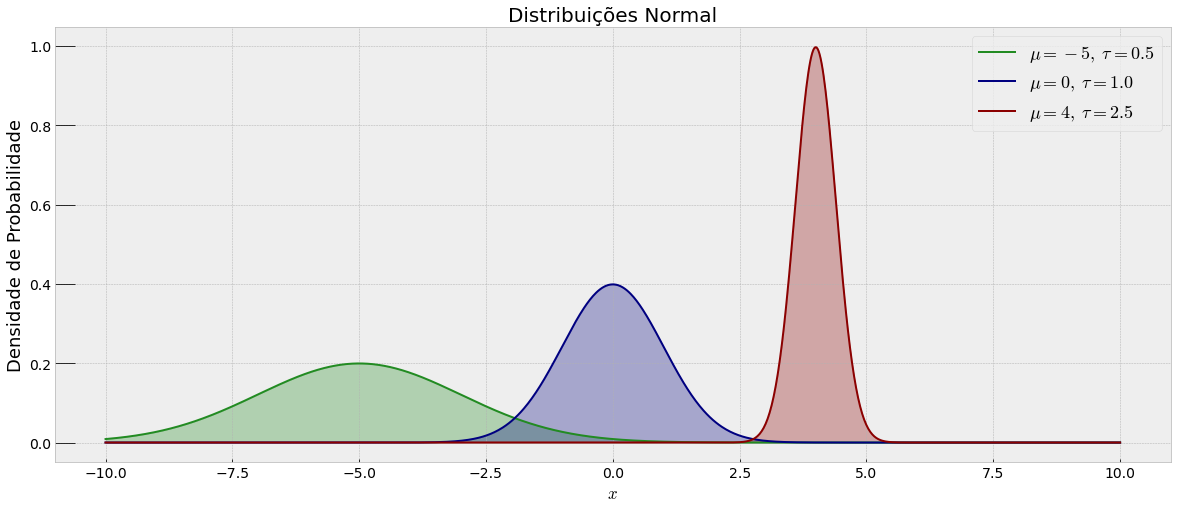

In [10]:
figsize(20, 8)
# Set up the plotting parameters
nor = stats.norm 
x= np.linspace(-10, 10, 1000)
mu = (-5, 0, 4)
tau = (0.5, 1, 2.5)
colors = ("forestgreen", "navy", "darkred")

# Plot 3 pdfs for different normal distributions
params = zip(mu, tau, colors)
for param in params:
    y = nor.pdf(x, loc = param[0], scale = 1 / param[1])
    plt.plot(x, y, 
             label="$\mu = %d,\;\\tau = %.1f$" % (param[0], param[1]), 
             color = param[2])
    plt.fill_between(x, y, color = param[2], alpha = 0.3)
    
plt.legend(prop={'size':18});
plt.xlabel("$x$")
plt.ylabel("Densidade de Probabilidade", size = 18)
plt.title("Distribui√ß√µes Normal", size = 20);

## Espa√ßo de Busca de Par√¢metros

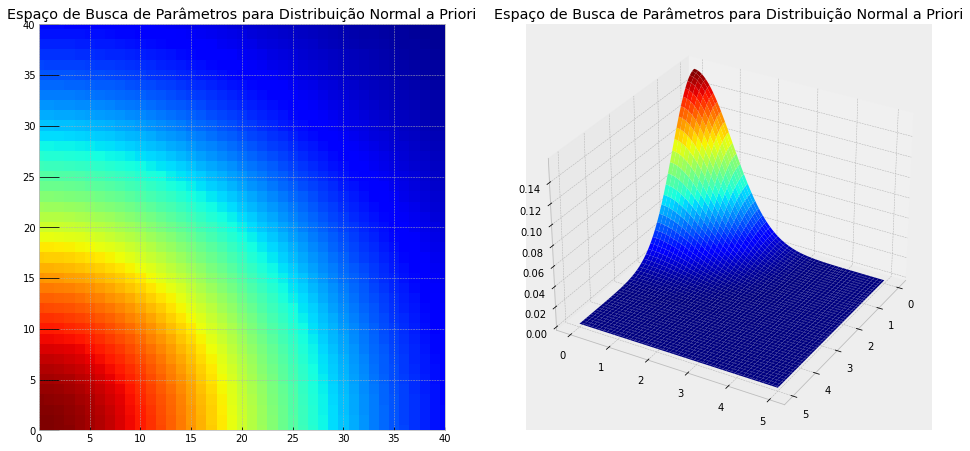

In [11]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(16, 8)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
norm_x = stats.norm.pdf(x, loc=0, scale=1)
norm_y = stats.norm.pdf(y, loc=0, scale=1)
M = np.dot(norm_x[:, None], norm_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet)

plt.xlim(0, 40)
plt.ylim(0, 40)
plt.title("Espa√ßo de Busca de Par√¢metros para Distribui√ß√£o Normal a Priori")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet)
ax.view_init(azim=390)
plt.title("Espa√ßo de Busca de Par√¢metros para Distribui√ß√£o Normal a Priori");

O valor esperado de uma distribui√ß√£o normal √© a m√©dia.
$$ E[ X | \mu, \tau] = \mu$$ 

A vari√¢ncia de uma distribui√ß√£o normal √© igual a:

$$ Var[ X | \mu, \tau) = \frac{1}{\tau}$$

Novamente, n√£o temos suposi√ß√µes sobre o valor de $\mu$ ou $\tau$ nas distribui√ß√µes anteriores de $\alpha$ e $\beta$.  

Quando inicializamos o modelo, podemos usar $\mu = 0$ e uma varia√ß√£o relativamente grande, como $\tau = 0,05$.   

A Cadeia de Markov Monte Carlo ir√° amostrar valores de $\mu$ e $\tau$ que tentam maximizar a probabilidade de $\alpha$ e $\beta$ sob os dados.

## Markov Chain Monte Carlo

A Cadeia de Markov Monte Carlo ir√° amostrar $\beta$ e $\alpha$ de duas distribui√ß√µes normais para encontrar os par√¢metros. A cada itera√ß√£o (estado), uma estimativa para $\beta$ e $\alpha$ √© extra√≠da do anterior.  

Se os par√¢metros aumentarem a probabilidade dos dados, o estado √© aceito, mas se os par√¢metros n√£o estiverem de acordo com os dados, o estado √© rejeitado.   

Monte Carlo refere-se √† parte de amostragem do algoritmo. 

Cadeia de Markov significa que o pr√≥ximo estado depende apenas do estado atual em um processo de primeira ordem (a segunda ordem depende da etapa atual e 1 etapa anterior, terceira ordem da etapa atual e 2 etapas anteriores e assim por diante). MCMC retornar√° cada amostra dos par√¢metros para o n√∫mero de etapas especificadas. 

Isso √© conhecido como rastreamento de modelo.  

Para encontrar os par√¢metros mais prov√°veis, podemos obter a m√©dia das amostras no rastreamento. 

MCMC n√£o d√° uma resposta exata, mas tenta encontrar os estados de m√°xima verossimilhan√ßa sob os dados.



Ao modelar com MCMC, at√© 50% das etapas iniciais, conhecidas como parte de burn-in do tra√ßo, s√£o descartadas porque o algoritmo retorna par√¢metros mais prov√°veis conforme o n√∫mero de amostras aumenta. As amostras iniciais s√£o menos prov√°veis ‚Äã‚Äãdo que as √∫ltimas amostras, em m√©dia. 

Existem v√°rios m√©todos para testar a converg√™ncia do MCMC, incluindo a inspe√ß√£o visual do tra√ßo e o c√°lculo da autocorrela√ß√£o do tra√ßo (uma autocorrela√ß√£o inferior √© um indicador de converg√™ncia).  

Examinaremos o tra√ßo neste exemplo, mas n√£o tomaremos medidas rigorosas para tratar da converg√™ncia. Existem tamb√©m v√°rios m√©todos para escolher um valor inicial inteligente para a Cadeia de Markov, como a estimativa de A Posterior M√°xima. A escolha de um valor inicial inteligente pode acelerar a converg√™ncia.

# Posterior Probability of Sleep given Time

Temos todas as pe√ßas para a probabilidade poesterior e agora podemos junt√°-las. A fun√ß√£o log√≠stica descreve a transi√ß√£o de acordado para adormecido, mas n√£o conhecemos os par√¢metros $ \beta$ e $\alpha$. 
O objetivo √© encontrar os par√¢metros da fun√ß√£o log√≠stica que maximizam a probabilidade dos dados observados. Os par√¢metros s√£o assumidos como vindo de uma distribui√ß√£o normal definida por uma m√©dia $\mu$ e uma vari√¢ncia $\tau$. 
O algoritmo MCMC ir√° amostrar valores de $\mu$ e $\tau$ para $\alpha$ e $\beta$ para tentar maximizar os par√¢metros da fun√ß√£o log√≠stica dados os dados.

Os dados s√£o conectados aos par√¢metros por meio de uma vari√°vel de Bernoulli.

## Bernoulli Variable

Uma vari√°vel bernoulli √© uma vari√°vel aleat√≥ria discreta que √© 0 ou 1. 

Em nosso exemplo, podemos modelar adormecido ou acordado como uma vari√°vel Bernoulli onde acordado √© 0 e adormecido √© 1. 

A vari√°vel Bernoulli para sono depende do tempo, em um forma definida pela fun√ß√£o log√≠stica.

$$ \text{ Probabilidade Sono, $S_i$} \sim \text{Ber}( \;p(t_i)\; ), \;\; i=1..N$$

$p(t_i)$ √© a fun√ß√£o log√≠stica com a vari√°vel independente tempo, ent√£o isso se torna: 

$$ P(\text{sono} | t_i) = \text{Ber}(\frac{1}{1 + e^{(\beta t_i + \alpha)}})$$

O objetivo do MCMC √© encontrar os par√¢metros $\alpha$ e $\beta$ usando os dados e assumindo antecedentes normais.

### Modelo PyMC3

Estamos usando uma poderosa biblioteca de infer√™ncia bayesiana em Python chamada PyMC3. Esta biblioteca possui recursos para executar Markov Chain Monte Carlo e outros algoritmos de infer√™ncia. Este relat√≥rio n√£o detalha o PyMC3, mas um √≥timo livro para come√ßar √© _Probabilistic Programming and Bayesian Methods for Hackers_ de Cameron Davidson-Pilon, que est√° dispon√≠vel gratuitamente em [GitHub](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

O c√≥digo a seguir cria o modelo e executa MCMC, usando `N_SAMPLES` number of samples for $\beta$ and $\alpha$. The specific sampling algorithm is [Metropolic Hastings](http://www.mit.edu/~ilkery/papers/MetropolisHastingsSampling.pdf). 

N√≥s alimentamos os dados e dizemos ao modelo que s√£o observa√ß√µes da vari√°vel de Bernoulli. O modelo ent√£o tenta maximizar os par√¢metros sob os dados.

In [12]:
# Sort the values by time offset
sleep_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(sleep_data.loc[:, 'time_offset'])

# Observations are the indicator
sleep_obs = np.array(sleep_data.loc[:, 'indicator'])

In [13]:
with pm.Model() as sleep_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=sleep_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    sleep_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 85 seconds.
The number of effective samples is smaller than 10% for some parameters.


A vari√°vel `trace` cont√©m todas as amostras retiradas da posterior para ùõΩ e ùõº. 

Podemos representar graficamente essas amostras para explorar como elas mudam no decorrer da amostragem. 

A ideia do MCMC √© que as amostras se tornam mais prov√°veis dados os dados conforme o algoritmo continua. 

Em outras palavras, o algoritmo MCMC converge nos valores mais prov√°veis conforme as amostras aumentam. 

Esperamos que os √∫ltimos valores extra√≠dos da parte posterior sejam mais precisos do que os valores anteriores. 

Na Cadeia de Markov Monte Carlo, √© pr√°tica comum descartar uma parte das amostras, geralmente cerca de 50%, que s√£o conhecidas como amostras de burn-in. 

Para este relat√≥rio, n√£o estou descartando nenhuma amostra, mas em um aplicativo real, executar√≠amos o modelo por muito mais etapas e descartaria as amostras iniciais.

## Visualize os posteriores para $\beta$ e $\alpha$

Os valores retornados no `trace` s√£o todas as amostras desenhadas para os par√¢metros. Podemos inspecionar visualmente esses valores em histogramas.

In [14]:
# Extract the alpha and beta samples
alpha_samples = sleep_trace["alpha"][5000:, None]
beta_samples = sleep_trace["beta"][5000:, None]

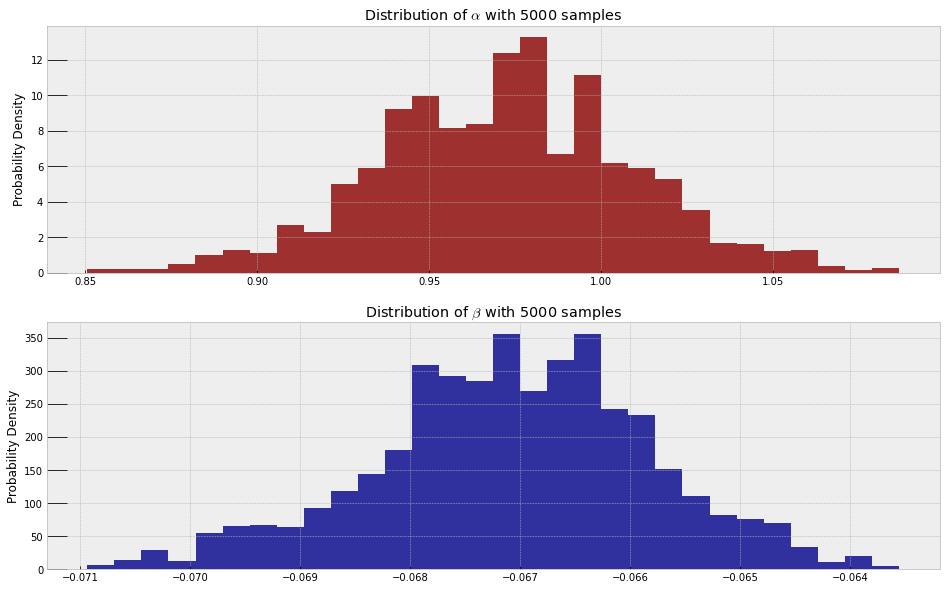

In [15]:
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha$ with %d samples""" % N_SAMPLES)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\beta$ with %d samples""" % N_SAMPLES)
plt.hist(beta_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');


Se os valores de ùõΩ estivessem centrados em torno de 0, isso indicaria que o tempo n√£o tem efeito na probabilidade de estar dormindo.

Os valores de ùõº tamb√©m n√£o est√£o em 0, indicando que h√° um deslocamento a partir das 22h em termos de estar dormindo.

Eu escolho representar os tempos como um deslocamento a partir das 22h para evitar lidar com os tempos de dados tanto quanto poss√≠vel.

A dissemina√ß√£o dos dados nos d√° uma medida de incerteza sobre os dados.

Um spread maior indica mais incerteza.

Como h√° uma sobreposi√ß√£o consider√°vel nas observa√ß√µes para acordado e dormindo, espera-se que a incerteza seja grande.

Para encontrar a distribui√ß√£o posterior mais prov√°vel para o sono de acordo com o tempo, tomamos a m√©dia das amostras ùõº e ùõΩ.

## Posterior para Visualiza√ß√£o de  Sono

In [16]:
# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
sleep_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

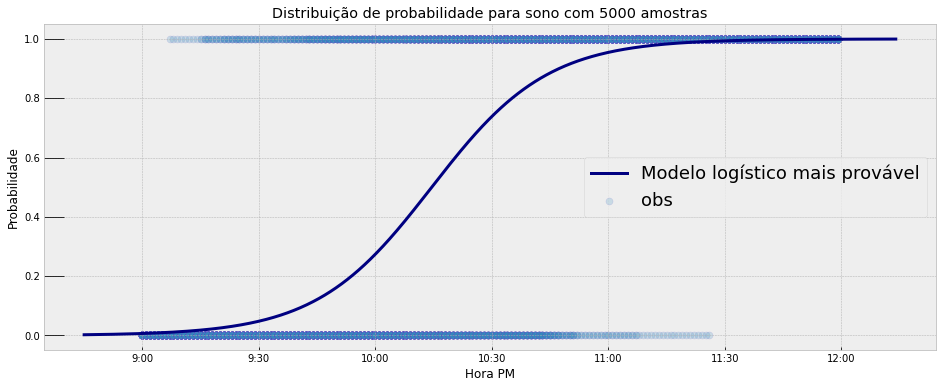

In [18]:
figsize(16, 6)

plt.plot(time_est, sleep_est, color = 'navy', 
         lw=3, label="Modelo log√≠stico mais prov√°vel")
plt.scatter(time, sleep_obs, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title('Distribui√ß√£o de probabilidade para sono com% d amostras' % N_SAMPLES);
plt.legend(prop={'size':18})
plt.ylabel('Probabilidade')
plt.xlabel('Hora PM');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

A probabilidade posterior aumenta de 0 para 1 conforme o tempo passa. O modelo n√£o √© perfeito devido ao ru√≠do nos dados, mas √© uma aproxima√ß√£o adequada com base nas observa√ß√µes e pode fornecer estimativas √∫teis.

In [19]:
print('A probabilidade de dormir aumenta para mais de 50% √†s 10:{} PM.'.format(int(time_est[np.where(sleep_est > 0.5)[0][0]][0])))

A probabilidade de dormir aumenta para mais de 50% √†s 10:14 PM.


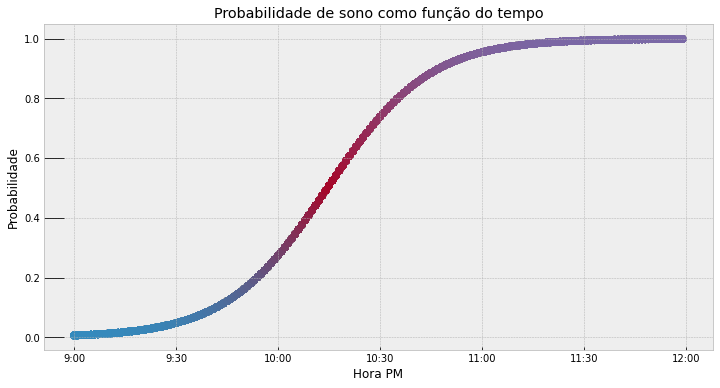

In [20]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = sleep_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probabilidade de sono como fun√ß√£o do tempo')
plt.xlabel('Hora PM');
plt.ylabel('Probabilidade');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);

O posterior pode ser consultado a qualquer momento (como um deslocamento a partir das 22h) para encontrar a probabilidade de eu estar dormindo.

In [21]:
print('10:00 PM Probabilidade de estar dormindo: {:.2f}%.'.
      format(100 * logistic(0, beta_est, alpha_est)))
print('9:30  PM Probabilidade de estar dormindo: {:.2f}%.'.
      format(100 * logistic(-30, beta_est, alpha_est)))
print('10:30 PM Probabilidade de estar dormindo: {:.2f}%.'.
      format(100 * logistic(30, beta_est, alpha_est)))

10:00 PM Probabilidade de estar dormindo: 27.44%.
9:30  PM Probabilidade de estar dormindo: 4.81%.
10:30 PM Probabilidade de estar dormindo: 73.88%.


### Intervalo de confian√ßa

Existem muitos outros diagn√≥sticos do modelo que podemos realizar. Por exemplo, sabemos que h√° uma quantidade consider√°vel de incerteza em nossas estimativas para $\alpha$ e $\beta$. Para refletir isso no gr√°fico, podemos incluir o intervalo de confian√ßa de 95% a cada vez com base em todas as amostras.

In [22]:
sleep_all_est = logistic(time_est.T, beta_samples, alpha_samples)
quantiles = stats.mstats.mquantiles(sleep_all_est, [0.025, 0.975], axis=0)

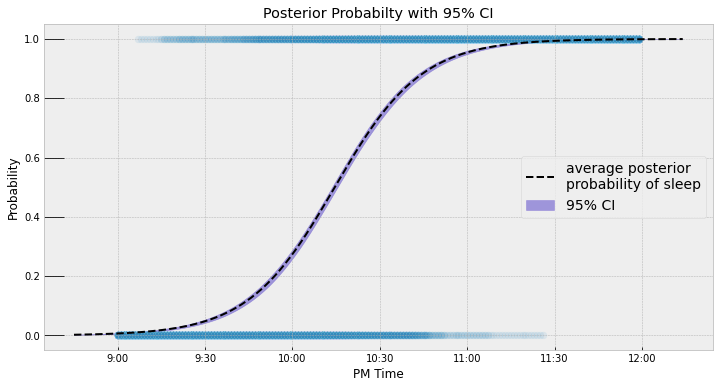

In [23]:
plt.fill_between(time_est[:, 0], *quantiles, alpha=0.6, 
                 color='slateblue', label = '95% CI')
plt.plot(time_est, sleep_est, lw=2, ls='--', 
         color='black', label="average posterior \nprobability of sleep")
plt.xticks([-60, -30, 0, 30, 60, 90, 120], sleep_labels);
plt.scatter(time, sleep_obs, edgecolor = 'skyblue', s=50, alpha=0.1);
plt.legend(prop={'size':14})
plt.xlabel('PM Time'); plt.ylabel('Probability'); 
plt.title('Posterior Probabilty with 95% CI');

At each time, there is a measure of uncertainty as to whether or not I am asleep. This represents the fact that MCMC does not return the True parameters.

## Distribui√ß√£o de probabilidade posterior para um tempo espec√≠fico

Tamb√©m podemos representar graficamente a distribui√ß√£o posterior do sono de cada vez como um histograma com base em todas as amostras dos par√¢metros. Isso nos d√° uma outra vis√£o da incerteza do modelo.

In [27]:
def sleep_posterior(time_offset, time):
    figsize(16, 8)
    prob = logistic(time_offset, beta_samples, alpha_samples)
    plt.hist(prob, bins=100, histtype='step', lw=4)
    plt.title('Distribui√ß√£o de probabilidade para sono em %s PM' % time)
    plt.xlabel('Probabilidade de Sono'); plt.ylabel('Samples')
    plt.show();

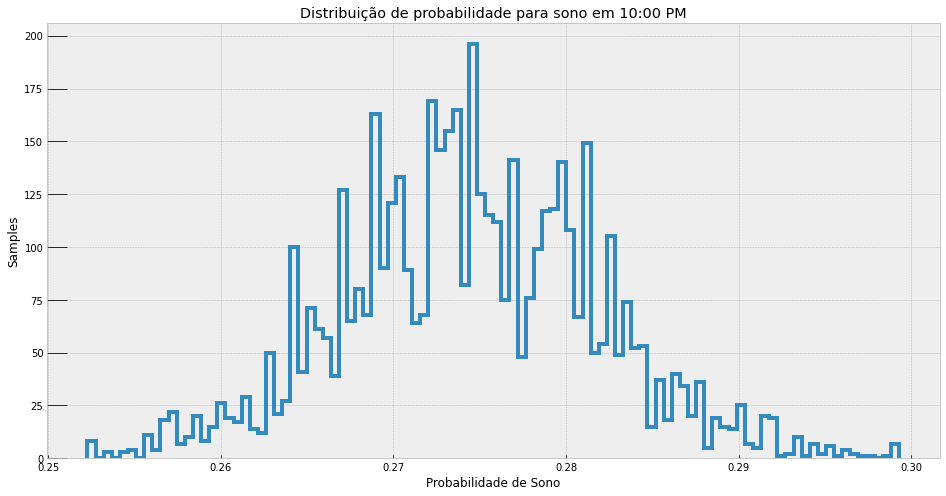

In [28]:
sleep_posterior(0, '10:00')

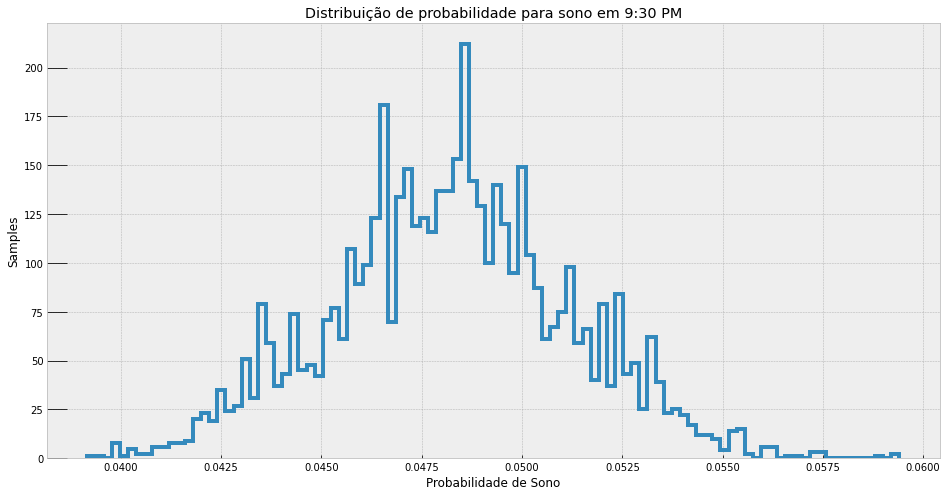

In [29]:
sleep_posterior(-30, '9:30')

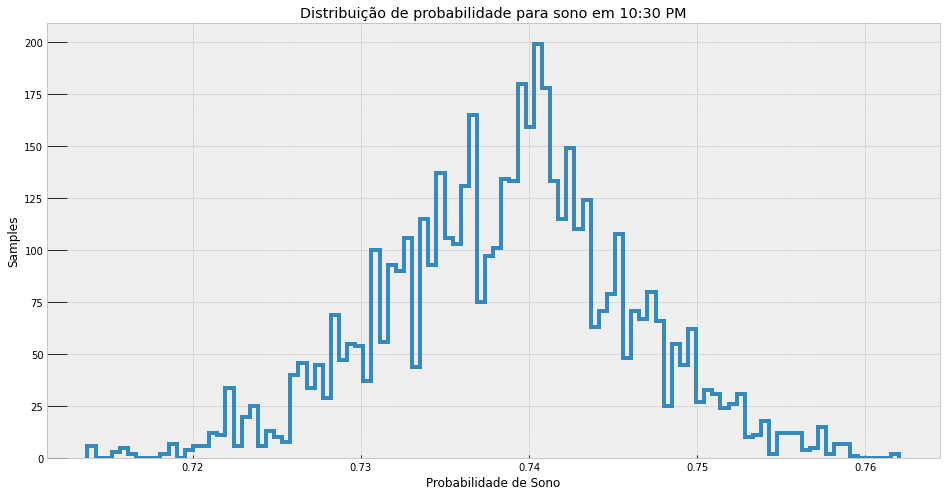

In [30]:
sleep_posterior(30, '10:30')

In [31]:
print('Most likely alpha parameter: {:.6f}.'.format(alpha_est))
print('Most likely beta  parameter: {:.6f}.'.format(beta_est))

Most likely alpha parameter: 0.972512.
Most likely beta  parameter: -0.067072.


## Converg√™ncia na Cadeia de Markov Monte Carlo

Como podemos saber se o modelo convergiu? Podemos observar o tra√ßo ou o caminho dos valores durante a amostragem. 

Outra op√ß√£o √© examinar a autocorrela√ß√£o das amostras. 

Na modelagem da Cadeia de Markov, as amostras s√£o correlacionadas com elas mesmas porque o pr√≥ximo valor depende do estado atual (ou o estado atual e os estados passados com base na ordem). 

Inicialmente, o algoritmo tende a vagar pelo espa√ßo de busca e ter√° uma alta autocorrela√ß√£o. Conforme o algoritmo converge, as amostras se estabelecer√£o em torno de um valor e uma medida de converg√™ncia √© uma baixa autocorrela√ß√£o. 

N√£o faremos um estudo rigoroso de converg√™ncia neste relat√≥rio, mas podemos tra√ßar os tra√ßos de todas as amostras.


## Trace Plots

The plots below show all the samples of $\alpha$ and $\beta$ from the algorithm.

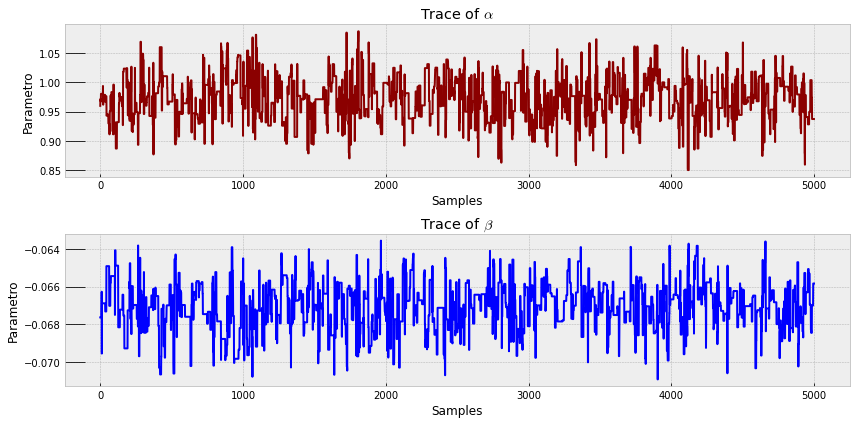

In [32]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parametro');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parametro');
plt.tight_layout(h_pad=0.8)


### Diagn√≥stico integrado

PyMC3 tem muitos diagn√≥sticos integrados para avalia√ß√£o de modelo. Aqui est√£o os gr√°ficos de rastreamento e de autocorrela√ß√£o. 

C:\Users\domin.DESKTOP-G0181GH\anaconda3\envs\Python36\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


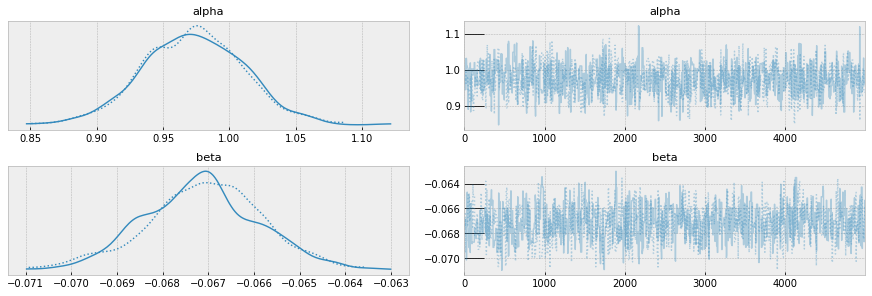

In [33]:
figsize(20, 12)
pm.traceplot(sleep_trace, ['alpha', 'beta']);

C:\Users\domin.DESKTOP-G0181GH\anaconda3\envs\Python36\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


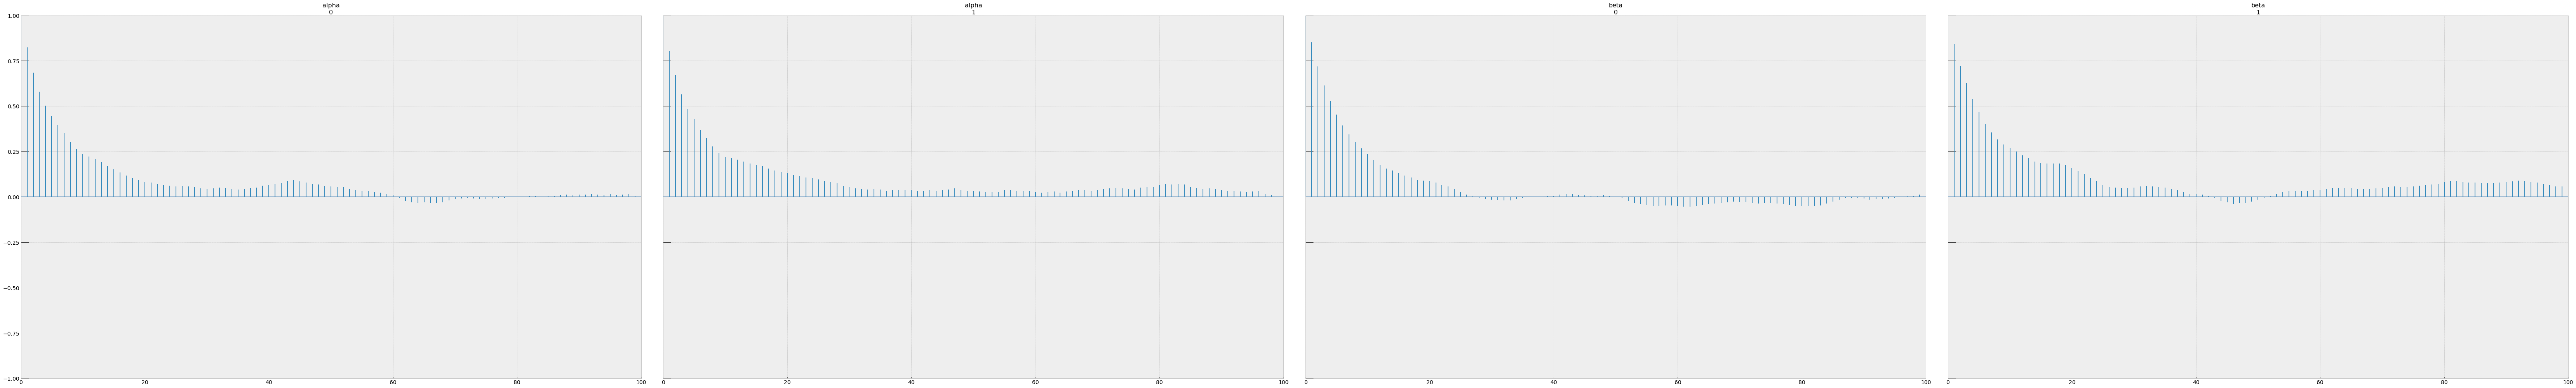

In [34]:
pm.autocorrplot(sleep_trace, ['alpha', 'beta']);

# Modelo Vig√≠lia (Wake)

Podemos repetir o mesmo procedimento para encontrar um modelo para os dados de vig√≠lia.

In [36]:
# Sort the values by time offset
wake_data.sort_values('time_offset', inplace=True)

# Time is the time offset
time = np.array(wake_data.loc[:, 'time_offset'])

# Observations are the indicator
wake_obs = np.array(wake_data.loc[:, 'indicator'])

with pm.Model() as wake_model:
    # Create the alpha and beta parameters
    alpha = pm.Normal('alpha', mu=0.0, tau=0.01, testval=0.0)
    beta = pm.Normal('beta', mu=0.0, tau=0.01, testval=0.0)
    
    # Create the probability from the logistic function
    p = pm.Deterministic('p', 1. / (1. + tt.exp(beta * time + alpha)))
    
    # Create the bernoulli parameter which uses the observed data
    observed = pm.Bernoulli('obs', p, observed=wake_obs)
    
    # Starting values are found through Maximum A Posterior estimation
    # start = pm.find_MAP()
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    wake_trace = pm.sample(N_SAMPLES, step=step);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [beta]
>Metropolis: [alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 86 seconds.
The number of effective samples is smaller than 10% for some parameters.


## Visualize Posterior para Wake dada hora

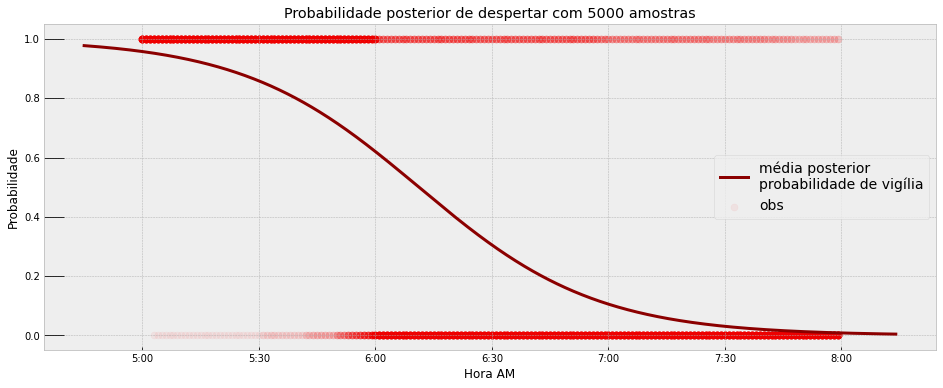

In [39]:
# Extract the alpha and beta samples
alpha_samples = wake_trace["alpha"][5000:, None]
beta_samples = wake_trace["beta"][5000:, None]

# Time values for probability prediction
time_est = np.linspace(time.min()- 15, time.max() + 15, 1000)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
wake_est = logistic(time_est, beta=beta_est, alpha=alpha_est)

figsize(16, 6)

plt.plot(time_est, wake_est, color = 'darkred', 
         lw=3, label="m√©dia posterior \nprobabilidade de vig√≠lia")
plt.scatter(time, wake_obs, edgecolor = 'r', facecolor = 'r', 
            s=50, alpha=0.05, label='obs')
plt.title('Probabilidade posterior de despertar com %d amostras' % N_SAMPLES);
plt.legend(prop={'size':14})
plt.ylabel('Probabilidade')
plt.xlabel('Hora AM');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

O modelo n√£o tem uma transi√ß√£o acentuada, que √© o que eu esperava porque tenho tend√™ncia a acordar por volta das 6h. V√°rias vezes, quando acordei v√°rias horas depois, mudou a curva para a direita.

In [40]:
print('A probabilidade de estar acordado passa de 50% em 6:{} AM.'.format(int(time_est[np.where(wake_est < 0.5)][0])))

A probabilidade de estar acordado passa de 50% em 6:11 AM.


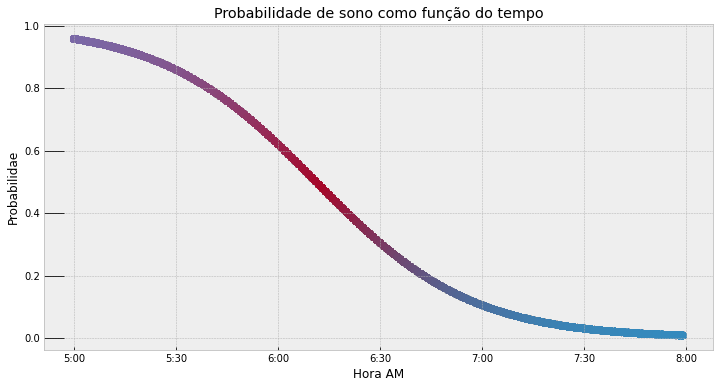

In [41]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("BMH", colors)
figsize(12, 6)
probs = wake_trace['p']

plt.scatter(time, probs.mean(axis=0), cmap = cmap, 
            c = probs.mean(axis=0), s = 50);
plt.title('Probabilidade de sono como fun√ß√£o do tempo')
plt.xlabel('Hora AM');
plt.ylabel('Probabilidae');
plt.xticks([-60, -30, 0, 30, 60, 90, 120], wake_labels);

## Investigue o modelo Wake

In [42]:
print('Probabilidade de estar acordado em 5:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(-30, beta=beta_est, alpha=alpha_est))))
print('Probabilidade de estar acordado em 6:00 AM: {:.2f}%.'.
      format(100 - (100 * logistic(0, beta=beta_est, alpha=alpha_est))))
print('Probabilidade de estar acordado em 6:30 AM: {:.2f}%.'.
      format(100 - (100 * logistic(30, beta=beta_est, alpha=alpha_est))))

Probabilidade de estar acordado em 5:30 AM: 14.14%.
Probabilidade de estar acordado em 6:00 AM: 37.97%.
Probabilidade de estar acordado em 6:30 AM: 69.47%.


# Modelo para dura√ß√£o do sono

Tamb√©m podemos formar um modelo para estimar o per√≠odo de tempo mais prov√°vel em que durmo. Podemos primeiro olhar para os dados e ent√£o determinar qual fun√ß√£o se ajusta √† distribui√ß√£o de probabilidade.

In [43]:
raw_data = pd.read_csv('data/sleep_wake.csv')
raw_data['length'] = 8 - (raw_data['Sleep'] / 60) + (raw_data['Wake'] / 60)
duration = raw_data['length']

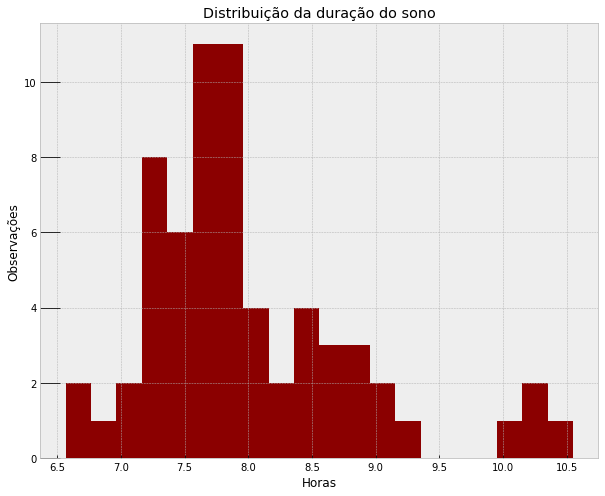

In [44]:
figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred')
plt.xlabel('Horas'); plt.title('Distribui√ß√£o da dura√ß√£o do sono'); 
plt.ylabel('Observa√ß√µes');

A distribui√ß√£o est√° inclinada para a direita. Portanto, podemos usar uma distribui√ß√£o enviesada para modelar a dura√ß√£o do sono.

Tamb√©m podemos querer usar uma distribui√ß√£o bimodal porque parece haver dois modos.

Por enquanto, vou me limitar a representar a dura√ß√£o da distribui√ß√£o do sono como uma normal distorcida. Uma distribui√ß√£o normal distorcida √© mostrada abaixo.

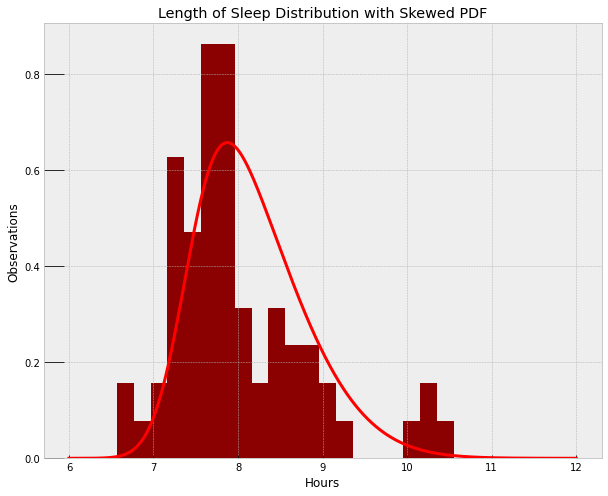

In [48]:
a = 3
fig, ax = plt.subplots(1, 1)
x = np.linspace(6, 12, 1000)


figsize(10, 8)
plt.hist(duration, bins = 20, color = 'darkred', density=True)
plt.xlabel('Hours'); plt.title('Length of Sleep Distribution with Skewed PDF'); 
plt.ylabel('Observations');
plt.plot(x, stats.skewnorm.pdf(x, a, loc = 7.4, scale=1), 'r-', 
         lw=3, label='skewnorm pdf');

In [49]:
with pm.Model() as duration_model:
    # Three parameters to sample
    alpha_skew = pm.Normal('alpha_skew', mu=0, tau=0.5, testval=3.0)
    mu_ = pm.Normal('mu', mu=0, tau=0.5, testval=7.4)
    tau_ = pm.Normal('tau', mu=0, tau=0.5, testval=1.0)
    
    # Duration is a deterministic variable
    duration_ = pm.SkewNormal('duration', alpha = alpha_skew, mu = mu_, 
                              sd = 1/tau_, observed = duration)
    
    # Metropolis Hastings for sampling
    step = pm.Metropolis()
    duration_trace = pm.sample(N_SAMPLES, step=step)
    

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [mu]
>Metropolis: [alpha_skew]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 21 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [50]:
# Extract the most likely estimates from the sampling
alpha_skew_samples = duration_trace['alpha_skew'][5000:]
mu_samples = duration_trace['mu'][5000:]
tau_samples = duration_trace['tau'][5000:]

alpha_skew_est = alpha_skew_samples.mean()
mu_est = mu_samples.mean()
tau_est = tau_samples.mean()

## Visualize a distribui√ß√£o posterior para a dura√ß√£o do sono

A dura√ß√£o mais prov√°vel do sono √© 7.65 hours.


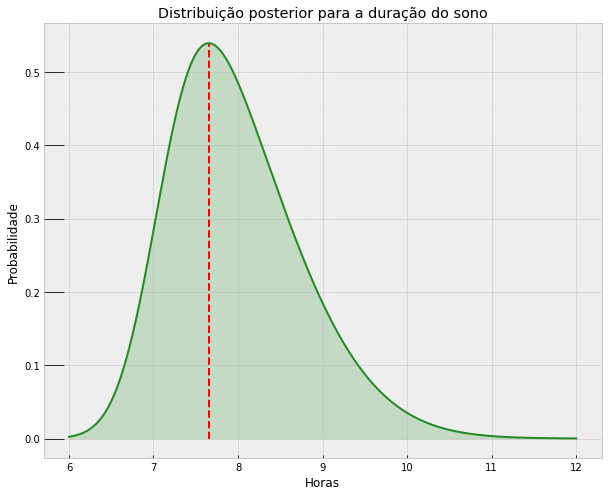

In [52]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
plt.plot(x, y, color = 'forestgreen')
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);
plt.xlabel('Horas'); plt.ylabel('Probabilidade'); 
plt.title('Distribui√ß√£o posterior para a dura√ß√£o do sono');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='red', 
           label = 'Dura√ß√£o Mais Prov√°vel');

print('A dura√ß√£o mais prov√°vel do sono √© {:.2f} hours.'.format(x[np.argmax(y)]))

### Consultar o modelo posterior

In [53]:
print('Probabilidade de pelo menos 6,5 horas de sono = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(6.5, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probabilidade de pelo menos 8,0 horas de sono = = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(8.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))
print('Probabilidade de pelo menos 9,0 horas de sono = = {:.2f}%.'.
      format(100 * (1 - stats.skewnorm.cdf(9.0, a = alpha_skew_est, loc = mu_est, scale = 1/tau_est))))

Probabilidade de pelo menos 6,5 horas de sono = 99.10%.
Probabilidade de pelo menos 8,0 horas de sono = = 44.19%.
Probabilidade de pelo menos 9,0 horas de sono = = 11.06%.


## Visualize o posterior e os dados

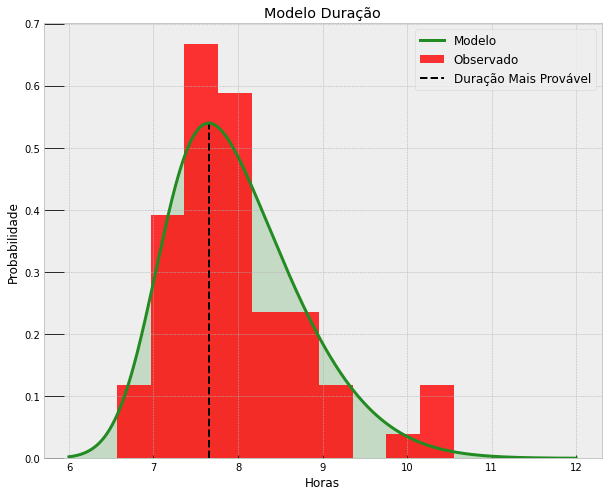

In [55]:
x = np.linspace(6, 12, 1000)
y = stats.skewnorm.pdf(x, a = alpha_skew_est, loc=mu_est, scale=1/tau_est)
figsize(10, 8)
# Plot the posterior distribution
plt.plot(x, y, color = 'forestgreen', 
         label = 'Modelo', lw = 3)
plt.fill_between(x, y, color = 'forestgreen', alpha = 0.2);

# Plot the observed values
plt.hist(duration, bins=10, color = 'red', alpha=0.8,
         label='Observado', density=True)
plt.xlabel('Horas'); plt.ylabel('Probabilidade'); 
plt.title('Modelo Dura√ß√£o');
plt.vlines(x = x[np.argmax(y)], ymin=0, ymax=y.max(), 
           linestyles='--', linewidth=2, color='k', 
           label = 'Dura√ß√£o Mais Prov√°vel');
plt.legend(prop={'size':12});

A distribui√ß√£o normal distorcida posterior parece ajustar-se bem aos dados.

No entanto, os dados podem ser melhor modelados como duas distribui√ß√µes separadas, dado o segundo modo √† direita.

  O segundo modo n√£o √© capturado em uma √∫nica distribui√ß√£o normal enviesada.

No geral, esse modelo ainda fornece uma estimativa razo√°vel para a probabilidade de dura√ß√£o do meu sono.

# Conclus√µes

Com base nas observa√ß√µes, podemos afirmar o seguinte:

* __Em m√©dia, adorme√ßo por volta das 22h14__
* __Em m√©dia, acordo √†s 6h11__
* __Minha dura√ß√£o m√©dia do sono √© de 7,67 horas__
    
Os modelos j√° me forneceram conhecimento sobre meus padr√µes de sono, e mais dados s√≥ melhorariam a aplicabilidade.

Eu poderia incorporar informa√ß√µes adicionais, como o dia da semana ou atividades di√°rias, para ver como elas afetam meu sono e, em seguida, fazer os ajustes necess√°rios.

Embora este relat√≥rio tenha feito v√°rias suposi√ß√µes e n√£o tenha investigado completamente os modelos, foi um √≥timo come√ßo para analisar dados reais com m√©todos bayesianos.

Projetos, especialmente com aplicativos reais, s√£o a melhor maneira de aprender, e estou ansioso para aplicar m√©todos bayesianos a problemas adicionais! 